In [1]:
import pandas as pd
import numpy as np
import duckdb
import json

# First: Review Existing Unstructured Data and Diagram a New Structured Relational Data Model

## Data Model Picture

The hard part is to find the key to join receipts and brands tables. I can think of two ways of connecting them: barcode or brandCode. I tried both and found using the brandCode as the key I can find more records after joining the receipts and brands tables. So I chose brandCode as the joinable key

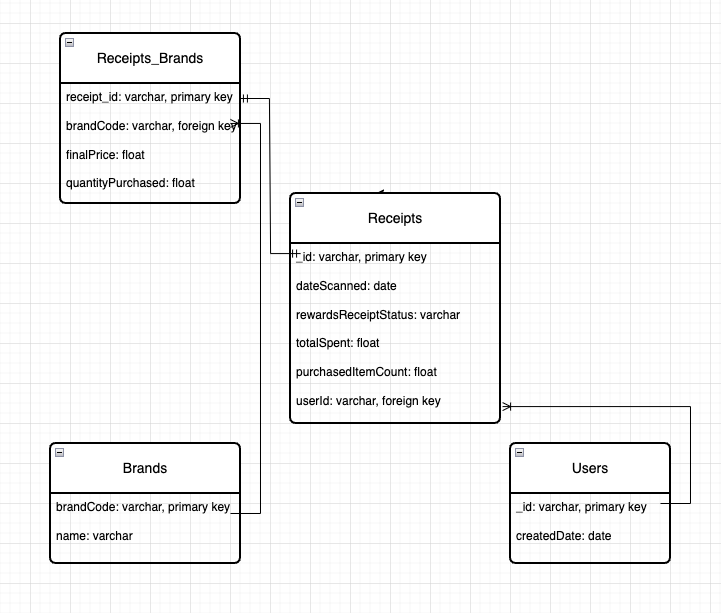

In [2]:
from IPython.display import Image
Image("Data Model.png")

### Create Data Model Tables from the JSON files based on the required questions.

### Then clean the tables: 1. Make the primary keys not null and not empty  2. Remove duplicates  3.Convert to correct data types

### Receipts Table

In [3]:
receipts_columns_lst = []
with open('receipts.json') as data_file:
    for line in data_file:
        receipts_columns = {}
        receipts_row = json.loads(line)
        if '_id' in receipts_row:
            receipts_columns['_id'] = receipts_row['_id']['$oid']
        if 'dateScanned' in receipts_row:
            receipts_columns['dateScanned'] = receipts_row['dateScanned']['$date']
        if 'rewardsReceiptStatus' in receipts_row:
            receipts_columns['rewardsReceiptStatus'] = receipts_row['rewardsReceiptStatus']
        if 'totalSpent' in receipts_row:
            receipts_columns['totalSpent'] = receipts_row['totalSpent']
        if 'purchasedItemCount' in receipts_row:
            receipts_columns['purchasedItemCount'] = receipts_row['purchasedItemCount']
        if 'userId' in receipts_row:
            receipts_columns['userId'] = receipts_row['userId']

        receipts_columns_lst.append(receipts_columns.copy()) 

In [4]:
receipts_df = pd.json_normalize(receipts_columns_lst)

In [5]:
receipts_df['dateScanned'] = pd.to_datetime(receipts_df['dateScanned'], unit='ms')
receipts_df['totalSpent'] = receipts_df['totalSpent'].astype(float)

In [6]:
receipts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   _id                   1119 non-null   object        
 1   dateScanned           1119 non-null   datetime64[ns]
 2   rewardsReceiptStatus  1119 non-null   object        
 3   totalSpent            684 non-null    float64       
 4   purchasedItemCount    635 non-null    float64       
 5   userId                1119 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 52.6+ KB


### Receipts_Brands Table

In [7]:
receipts_brands_columns_lst = []
with open('receipts.json') as data_file:
    for line in data_file:
        receipts_brands_row = json.loads(line)
        if 'rewardsReceiptItemList' in receipts_brands_row: #some rows don't have rewardsReceiptItemList
            receipts_brands_columns = {}
            
            for item in receipts_brands_row['rewardsReceiptItemList']:
                
                receipts_brands_columns['receipt_id'] = receipts_brands_row['_id']['$oid'] #the primary key
                
                if 'brandCode' in item: # some item list has no brandcode, if not make it as null
                    receipts_brands_columns['brandCode'] = item['brandCode']
                    
                if 'finalPrice' in item: 
                    receipts_brands_columns['finalPrice'] = item['finalPrice']
                    
                if 'quantityPurchased' in item: 
                    receipts_brands_columns['quantityPurchased'] = item['quantityPurchased']
                    
                receipts_brands_columns_lst.append(receipts_brands_columns.copy()) 
                    
    

In [8]:
receipts_brands_df = pd.json_normalize(receipts_brands_columns_lst)

In [9]:
receipts_brands_df['finalPrice'] = receipts_brands_df ['finalPrice'].astype(float)

In [10]:
#receipts_brands_df = receipts_brands_df.drop_duplicates() 
#not drop duplicates because I think it is possible that one receipt can have multiple items with same price and quantity from same brand

In [11]:
receipts_brands_df = receipts_brands_df[~receipts_brands_df['brandCode'].isnull()] #delete the entries that brandCode is null
receipts_brands_df = receipts_brands_df[receipts_brands_df['brandCode'] != ''] #delete the entries that brandCode is empty

In [12]:
#since brandCode is the joinable key to solve the questions, i clean out the brandCode fields with null or empty values
receipts_brands_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5275 entries, 8 to 6847
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   receipt_id         5275 non-null   object 
 1   finalPrice         5275 non-null   float64
 2   quantityPurchased  5275 non-null   float64
 3   brandCode          5275 non-null   object 
dtypes: float64(2), object(2)
memory usage: 206.1+ KB


### Brands Table

In [13]:
brands_columns_lst = []
with open('brands.json') as data_file:
    for line in data_file:
        brands_columns = {}
        brands_row = json.loads(line)
        if 'brandCode' in brands_row:
            brands_columns['brandCode'] = brands_row['brandCode']
        if 'name' in brands_row:
            brands_columns['name'] = brands_row['name']
            
        brands_columns_lst.append(brands_columns.copy())

In [14]:
brands_df = pd.json_normalize(brands_columns_lst)

In [15]:
brands_df = brands_df.drop_duplicates()

In [16]:
duckdb.query('''SELECT brandCode, COUNT(name) as name_count 
FROM brands_df 
GROUP BY 1
HAVING COUNT(name)>=2
''') #'GOODNITES' has two names

┌───────────┬────────────┐
│ brandCode │ name_count │
│  varchar  │   int64    │
├───────────┼────────────┤
│ NULL      │        234 │
│ GOODNITES │          2 │
│           │         35 │
└───────────┴────────────┘

In [17]:
duckdb.query('''SELECT *
FROM brands_df 
WHERE brandCode in ('GOODNITES')
''') #upper and lower case difference

┌───────────┬───────────┐
│   name    │ brandCode │
│  varchar  │  varchar  │
├───────────┼───────────┤
│ GoodNites │ GOODNITES │
│ Goodnites │ GOODNITES │
└───────────┴───────────┘

In [18]:
brands_df = brands_df[brands_df.name != 'Goodnites'] #clean out the extra entry

In [19]:
brands_df = brands_df[~brands_df['brandCode'].isnull()] #delete the entries that brandCode is null

In [20]:
brands_df = brands_df[brands_df['brandCode'] != '']#delete the entries that brandCode is empty

In [21]:
#since brandCode is the joinable key to solve the questions, i clean out the brandCode fields with null or empty values
brands_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 896 entries, 1 to 1166
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       896 non-null    object
 1   brandCode  896 non-null    object
dtypes: object(2)
memory usage: 21.0+ KB


In [22]:
duckdb.query('''SELECT brandCode, COUNT(name) as name_count 
FROM brands_df 
GROUP BY 1
HAVING COUNT(name)>=2
''') #now brandCode has unique name

┌───────────┬────────────┐
│ brandCode │ name_count │
│  varchar  │   int64    │
├───────────┴────────────┤
│         0 rows         │
└────────────────────────┘

### Users Table

In [23]:
users_columns_lst = []
with open('users.json') as data_file:
    for line in data_file:
        users_columns = {}
        users_row = json.loads(line)
        if '_id' in users_row:
            users_columns['_id'] = users_row['_id']['$oid']
        if 'createdDate' in users_row:
            users_columns['createdDate'] = users_row['createdDate']['$date']
            
        users_columns_lst.append(users_columns.copy())

In [24]:
users_df = pd.json_normalize(users_columns_lst)

In [25]:
users_df['createdDate'] = pd.to_datetime(users_df['createdDate'], unit='ms')

In [26]:
duckdb.query('''SELECT _id, COUNT(createdDate) as create_date_count 
FROM users_df 
GROUP BY 1
HAVING COUNT(createdDate)>=2
''') #have duplicates

┌──────────────────────────┬───────────────────┐
│           _id            │ create_date_count │
│         varchar          │       int64       │
├──────────────────────────┼───────────────────┤
│ 5ff1e1eacfcf6c399c274ae6 │                 4 │
│ 5ff36d0362fde912123a5535 │                 3 │
│ 5ff4ce33c3d63511e2a484b6 │                 7 │
│ 5ff8da28b3348b11c9337ac6 │                 2 │
│ 5ff873ddb3348b11c9337733 │                 2 │
│ 5ffe115404929101d0aaebb2 │                 2 │
│ 600056a3f7e5b011fce897b0 │                 8 │
│ 6009e60450b3311194385009 │                 3 │
│ 60145ff384231211ce796d51 │                 2 │
│ 5ff1e194b6a9d73a3a9f1052 │                11 │
│            ·             │                 · │
│            ·             │                 · │
│            ·             │                 · │
│ 5ff4ce3dc3d63511e2a484dc │                 4 │
│ 5fff55dabd4dff11dda8f5f1 │                 7 │
│ 6000d46cfb296c121a81b20c │                 2 │
│ 6000b75bbe5fc96dfe

In [27]:
users_df = users_df.drop_duplicates() #users_df has duplicates, so dropping duplicates

In [28]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212 entries, 0 to 475
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   _id          212 non-null    object        
 1   createdDate  212 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 5.0+ KB


#### Display the tables

In [29]:
users_df.head()

,_id,createdDate
0,5ff1e194b6a9d73a3a9f1052,2021-01-03 15:24:04.800
3,5ff1e1eacfcf6c399c274ae6,2021-01-03 15:25:30.554
6,5ff1e1e8cfcf6c399c274ad9,2021-01-03 15:25:28.354
7,5ff1e1b7cfcf6c399c274a5a,2021-01-03 15:24:39.626
9,5ff1e1f1cfcf6c399c274b0b,2021-01-03 15:25:37.564


In [30]:
receipts_df.head()

,_id,dateScanned,rewardsReceiptStatus,totalSpent,purchasedItemCount,userId
0,5ff1e1eb0a720f0523000575,2021-01-03 15:25:31,FINISHED,26.0,5.0,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,2021-01-03 15:24:43,FINISHED,11.0,2.0,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,2021-01-03 15:25:37,REJECTED,10.0,1.0,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,2021-01-03 15:25:34,FINISHED,28.0,4.0,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,2021-01-03 15:25:06,FINISHED,1.0,2.0,5ff1e194b6a9d73a3a9f1052


In [31]:
receipts_brands_df.head()

,receipt_id,finalPrice,quantityPurchased,brandCode
8,5ff1e1cd0a720f052300056f,2.23,1.0,MISSION
9,5ff1e1a40a720f0523000569,10.00,1.0,BRAND
150,5ff29be20a7214ada1000571,1.00,1.0,KRAFT EASY CHEESE
306,5ff618e30a7214ada10005fa,1.96,2.0,PEPSI
307,5ff618e30a7214ada10005fa,7.53,3.0,PEPSI


In [32]:
brands_df.head()

,name,brandCode
1,Starbucks,STARBUCKS
2,test brand @1612366146176,TEST BRANDCODE @1612366146176
3,test brand @1612366146051,TEST BRANDCODE @1612366146051
4,test brand @1612366146827,TEST BRANDCODE @1612366146827
5,test brand @1612366146091,TEST BRANDCODE @1612366146091


# Second: Write queries that directly answer predetermined questions from a business stakeholder

### 1. What are the top 5 brands by receipts scanned for most recent month?

In [33]:
duckdb.query('''
--First make the table with relevant fileds: brands in receipts scanned at different dates

WITH receipt_brand_scanned as (
SELECT a.receipt_id, b.dateScanned, c.name
FROM receipts_brands_df a 
JOIN receipts_df b 
ON a.receipt_id = b._id 
JOIN brands_df c 
ON a.brandCode = c.brandCode)

--There is no clear definition about 'most recent month'. 
--So I am assuming the most recent month is the current month of the latest scanned date

SELECT name as brand_name, COUNT(*) as brands_scanned_count
FROM receipt_brand_scanned
WHERE date_trunc('month',dateScanned) = (SELECT date_trunc('month',max(dateScanned)) FROM receipt_brand_scanned)
GROUP BY 1
ORDER BY brands_scanned_count DESC
LIMIT 5
''').to_df()

,brand_name,brands_scanned_count
0,Viva,1


### How does the ranking of the top 5 brands by receipts scanned for the recent month compare to the ranking for the previous month?

In [34]:
#I do the same thing as Q1 for the previous month, and then we can compare against the two tables to gain insight
# In this case, we only have one brand scanned this month so not much stuff to compare

duckdb.query('''
WITH receipt_brand_scanned as (
SELECT a.receipt_id, b.dateScanned, c.name
FROM receipts_brands_df a 
JOIN receipts_df b 
ON a.receipt_id = b._id 
JOIN brands_df c 
ON a.brandCode = c.brandCode)


SELECT name as brand_name, COUNT(*) as brands_scanned_count
FROM receipt_brand_scanned
WHERE date_trunc('month',dateScanned) = (SELECT date_trunc('month',max(dateScanned)) - interval '1 month'
FROM receipt_brand_scanned)
GROUP BY 1
ORDER BY brands_scanned_count DESC
LIMIT 5
''').to_df()

,brand_name,brands_scanned_count
0,Pepsi,152
1,Kleenex,150
2,Doritos,149
3,KNORR,133
4,Kraft,71


### When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

In [35]:
# rewardsReceiptStatus has five status: FLAGGED, SUBMITTED, PENDING, REJECTED, FINISHED. 
# I am assuming 'Finished' as 'Accepted'
# Also, I take totalSpent field as the spend from each receipt, and take avg of the totalSpent by rewardsReceiptStatus

duckdb.query(''' 
SELECT rewardsReceiptStatus, avg(totalSpent) as avg_spent
FROM (
SELECT rewardsReceiptStatus, totalSpent
FROM receipts_df
WHERE rewardsReceiptStatus in ('FINISHED','REJECTED')
)
GROUP BY 1
''').to_df()

,rewardsReceiptStatus,avg_spent
0,FINISHED,80.854305
1,REJECTED,23.326056


'Accepted'('FINISHED') is greater

### When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

In [36]:
# I take purchasedItemCount field as the spend from each receipt

duckdb.query(''' 
SELECT rewardsReceiptStatus, avg(purchasedItemCount) as avg_item_count
FROM (
SELECT rewardsReceiptStatus, purchasedItemCount
FROM receipts_df
WHERE rewardsReceiptStatus in ('FINISHED','REJECTED')
)
GROUP BY 1
''').to_df()

,rewardsReceiptStatus,avg_item_count
0,FINISHED,15.799228
1,REJECTED,2.436620


'Accepted'('FINISHED') is greater

### Which brand has the most spend among users who were created within the past 6 months?

In [37]:
#Since this question asks for the spend by brand, 
#I am not using totalSpent from receipts table because this amount could be composed by multiple brands
#Instead, I use the brand items from the rewardsReceiptItemList, and take the finalPrice * quantityPurchased as the spend for each brand item
#Then I sum up the spend for each brand for all users who created their account in last 6 month

#There is no clear definition 'past 6 months', so I am taking the latest scannedDate for receipt as the latest date
#Then I take the past 6 months from the latest date as the time range to filter the users by their creation date

duckdb.query(''' 
WITH receipts_brand_user_all as (
SELECT a.receipt_id, a.finalPrice * a.quantityPurchased as spent,b.dateScanned, c.name, d._id as user_id, d.createdDate
FROM receipts_brands_df a 
JOIN receipts_df b 
ON a.receipt_id = b._id 
JOIN brands_df c 
ON a.brandCode = c.brandCode
JOIN users_df d
ON b.userId = d._id)

SELECT name as brand_name, sum(spent) as total_spent
FROM receipts_brand_user_all
WHERE createdDate >= (SELECT date_trunc('month',max(dateScanned)) - interval '6 month'
FROM receipts_brand_user_all)
GROUP BY 1
ORDER BY total_spent DESC
LIMIT 1
''').to_df()

,brand_name,total_spent
0,Cracker Barrel Cheese,12748.21


### Which brand has the most transactions among users who were created within the past 6 months?

In [38]:
#Similar as the question above, i first make the table to include the purchased brand items by receipts and users

#This question asks for 'transaction' without giving clear definition.
#I am counting the number of times a brand appeared on the receipts as the number of transactions
#If a brand appeared two times on the same receipt, then the transaction is two

duckdb.query(''' 
WITH receipts_brand_user_all as (
SELECT a.receipt_id, b.dateScanned, c.name, d._id as user_id, d.createdDate
FROM receipts_brands_df a 
JOIN receipts_df b 
ON a.receipt_id = b._id 
JOIN brands_df c 
ON a.brandCode = c.brandCode
JOIN users_df d
ON b.userId = d._id)

SELECT name as brand_name, count(*) as transcation 
FROM receipts_brand_user_all
WHERE createdDate >= (SELECT date_trunc('month',max(dateScanned)) - interval '6 month'
FROM receipts_brand_user_all)
GROUP BY 1
ORDER BY transcation DESC
LIMIT 1
''').to_df()

,brand_name,transcation
0,Kleenex,124


# Third: Evaluate Data Quality Issues in the Data Provided

The first thing I did when I have the files was to do some descriptive analysis(e.g. column types, values distributions, null values, etc.,) and try to understand the datasets as much as I can. The process is tedious and the code is lengthy, so here I just show the findings that I think are suspicous and might have quality issues

### Receipts file

In [39]:
# some userId in receipts file cannot be found in Users file
duckdb.query('''
SELECT * from 
receipts_df
WHERE userId not in (SELECT distinct _id from users_df)''').to_df()

,_id,dateScanned,rewardsReceiptStatus,totalSpent,purchasedItemCount,userId
0,5f9c74f70a7214ad07000037,2020-10-30 20:17:59,REJECTED,1.00,11.0,5f9c74f7c88c1415cbddb839
1,5ff1e1e90a7214ada1000569,2021-01-03 15:25:29,FLAGGED,0.00,0.0,5ff1e1e9b6a9d73a3a9f10f6
2,5ff1e1df0a7214ada1000564,2021-01-03 15:25:19,FINISHED,11.00,2.0,5ff1e1dfcfcf6c399c274ab3
3,5f9c74f90a7214ad07000038,2020-10-30 20:18:01,FINISHED,14.00,6.0,5f9c74e3f1937815bd2c1d73
4,5ff1e1960a720f0523000567,2021-01-03 15:24:06,FINISHED,1.00,1.0,5ff1e196cfcf6c399c274a38
...,...,...,...,...,...,...
143,602538740a7214d8e9000246,2021-02-11 14:00:20,FINISHED,2.23,1.0,60253861efa6017a44dc6b50
144,602538920a720f05a8000216,2021-02-11 14:00:50,FINISHED,20.00,5.0,60253891b54593795bf69242
145,602538960a720f05a800021b,2021-02-11 14:00:53,FINISHED,23.00,2.0,60253891b54593795bf69242
146,60268c7e0a7214d8e9000309,2021-02-12 14:11:10,FINISHED,29.00,3.0,60268c7bb545931ac63683af


In [40]:
#a lot brandCode in receipts' rewardsReceiptItemList cannot be found in the brands file
duckdb.query('''
SELECT distinct brandCode from 
receipts_brands_df 
WHERE brandCode not in (SELECT distinct brandCode from brands_df)''').to_df()

,brandCode
0,LIGHT & FIT GREEK
1,EL MONTEREY
2,LAURA'S LEAN BEEF
3,THAT'S SMART!
4,SO DELICIOUS
...,...
181,EGGLAND'S BEST
182,TOP FLIGHT
183,HORMEL
184,7UP


In [41]:
#expanding the json file into dataframe
receipts_lst = []
with open('receipts.json') as data_file:
    for line in data_file:
        receipts_lst.append(json.loads(line))
        
receipts_check = pd.json_normalize(receipts_lst)

In [42]:
receipts_check = receipts_check.rename(columns = {'_id.$oid':'_id','createDate.$date':'createDate', 'dateScanned.$date':'dateScanned',
                             'finishedDate.$date':'finishedDate', 'modifyDate.$date':'modifyDate', 'pointsAwardedDate.$date':'pointsAwardedDate',
                             'purchaseDate.$date':'purchaseDate'})
#convert columns types
receipts_check['pointsEarned'] = receipts_check['pointsEarned'].astype(float)
receipts_check['totalSpent'] = receipts_check['totalSpent'].astype(float)
receipts_check['finishedDate'] = receipts_check['finishedDate'].astype('Int64')
receipts_check['pointsAwardedDate'] = receipts_check['pointsAwardedDate'].astype('Int64')
receipts_check['purchaseDate'] = receipts_check['purchaseDate'].astype('Int64')
receipts_check['createDate'] = pd.to_datetime(receipts_check['createDate'], unit='ms')
receipts_check['dateScanned'] = pd.to_datetime(receipts_check['dateScanned'], unit='ms')
receipts_check['finishedDate'] = pd.to_datetime(receipts_check['finishedDate'], unit='ms')
receipts_check['modifyDate'] = pd.to_datetime(receipts_check['modifyDate'], unit='ms')
receipts_check['pointsAwardedDate'] = pd.to_datetime(receipts_check['pointsAwardedDate'], unit='ms')
receipts_check['purchaseDate'] = pd.to_datetime(receipts_check['purchaseDate'], unit='ms')

In [43]:
#purchaseDate later than pointsAwardedDate
receipts_check[receipts_check['purchaseDate'] > receipts_check['pointsAwardedDate']].head()

,bonusPointsEarned,bonusPointsEarnedReason,pointsEarned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId,_id,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,purchaseDate
14,300.0,"Receipt number 4 completed, bonus point schedu...",300.0,1.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.0,5ff1e194b6a9d73a3a9f1052,5ff1e1b20a7214ada100055a,2021-01-03 15:24:34,2021-01-03 15:24:34,2021-01-03 15:24:35,2021-01-03 15:24:35,2021-01-03 15:24:35,2021-02-03 15:24:35
85,25.0,COMPLETE_NONPARTNER_RECEIPT,25.0,1.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.0,5ff4ce33c3d63511e2a484b6,5ff4ce640a7214ada10005e0,2021-01-05 20:39:00,2021-01-05 20:39:00,2021-01-05 20:39:00,2021-01-05 20:39:00,2021-01-05 20:39:00,2021-02-05 20:39:00
244,25.0,COMPLETE_NONPARTNER_RECEIPT,25.0,1.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.0,5fff2698b3348b03eb45bb10,5fff26ee0a720f05f300001a,2021-01-13 16:59:26,2021-01-13 16:59:26,2021-01-13 16:59:26,2021-01-13 16:59:26,2021-01-13 16:59:26,2021-02-13 16:59:26
362,250.0,"Receipt number 3 completed, bonus point schedu...",250.0,1.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.0,6008873eb6310511daa4e8eb,600887560a720f05fa000098,2021-01-20 19:41:10,2021-01-20 19:41:10,2021-01-20 19:41:11,2021-01-20 19:41:11,2021-01-20 19:41:11,2021-02-20 19:41:10
553,750.0,"Receipt number 1 completed, bonus point schedu...",750.0,1.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.0,60145a3c84231211ce796c5d,60145a3d0a7214ad50000082,2021-01-29 18:55:57,2021-01-29 18:55:57,2021-01-29 18:56:00,2021-01-29 18:56:00,2021-01-29 18:56:00,2021-02-28 18:55:58


In [44]:
#no spent but earned points
receipts_check[(receipts_check['totalSpent'] == 0) & (receipts_check['pointsEarned'] > 0)]

,bonusPointsEarned,bonusPointsEarnedReason,pointsEarned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId,_id,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,purchaseDate
396,250.0,"Receipt number 3 completed, bonus point schedu...",250.0,0.0,NaN,FINISHED,0.0,6009e60450b3311194385009,6009eb000a7214ada2000003,2021-01-21 20:58:40,2021-01-21 20:58:40,2021-01-21 20:59:06,2021-01-21 20:59:15,2021-01-21 20:59:06,2021-01-21
424,500.0,"Receipt number 2 completed, bonus point schedu...",500.0,0.0,NaN,FINISHED,0.0,600afb2a7d983a124e9aded0,600aff160a720f053500000c,2021-01-22 16:36:38,2021-01-22 16:36:38,2021-01-22 16:37:01,2021-01-22 16:37:13,2021-01-22 16:37:01,2021-01-22


In [45]:
#receipts rejected but earned points
receipts_check[(receipts_check['rewardsReceiptStatus'] == 'REJECTED') & (receipts_check['pointsEarned'] > 0)].head()

,bonusPointsEarned,bonusPointsEarnedReason,pointsEarned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId,_id,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,purchaseDate
2,5.0,All-receipts receipt bonus,5.0,1.0,"[{'needsFetchReview': False, 'partnerItemId': ...",REJECTED,10.00,5ff1e1f1cfcf6c399c274b0b,5ff1e1f10a720f052300057a,2021-01-03 15:25:37,2021-01-03 15:25:37,NaT,2021-01-03 15:25:42,NaT,2021-01-03 00:00:00
13,750.0,"Receipt number 1 completed, bonus point schedu...",750.0,11.0,"[{'barcode': '075925306254', 'competitiveProdu...",REJECTED,1.00,5f9c74f7c88c1415cbddb839,5f9c74f70a7214ad07000037,2020-10-30 20:17:59,2020-10-30 20:17:59,NaT,2021-01-03 15:24:54,2020-10-30 20:18:00,2020-10-29 20:17:59
62,750.0,"Receipt number 1 completed, bonus point schedu...",750.0,2.0,[{'description': 'mueller austria hypergrind p...,REJECTED,34.96,5fbc35711d967d1222cbfefc,5ff4a4ca0a7214ada10005d0,2021-01-05 17:41:30,2021-01-05 17:41:30,NaT,2021-01-05 17:41:32,NaT,2020-09-13 00:00:00
203,5.0,All-receipts receipt bonus,5.0,1.0,"[{'barcode': '4011', 'finalPrice': '24.00', 'i...",REJECTED,10.00,5ffc9d9cb3348b11c933893f,5ffc9d9c0a7214adca00004b,2021-01-11 18:49:00,2021-01-11 18:49:00,NaT,2021-01-11 18:49:05,NaT,2021-01-11 00:00:00
207,5.0,All-receipts receipt bonus,5.0,1.0,"[{'barcode': '4011', 'finalPrice': '22.00', 'i...",REJECTED,10.00,5ffcb4b8b3348b11c9338ae1,5ffcb4b80a7214ad4e00000d,2021-01-11 20:27:36,2021-01-11 20:27:36,NaT,2021-01-11 20:27:41,NaT,2021-01-11 00:00:00


In [46]:
for index, row in receipts_check.iterrows():
    itemCount = 0
    if isinstance(row['rewardsReceiptItemList'], list):
        for item in row['rewardsReceiptItemList']:
            if 'quantityPurchased' in item:
                itemCount = itemCount + float(item['quantityPurchased'])
        receipts_check.loc[index, 'rewardsReceiptItemList_quantityPurchased'] = itemCount

In [47]:
#purchasedItemCount not equal to the purchased count sum in the rewardsReceiptItemList
receipts_check[receipts_check['purchasedItemCount'] != receipts_check['rewardsReceiptItemList_quantityPurchased']].head()

,bonusPointsEarned,bonusPointsEarnedReason,pointsEarned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId,_id,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,purchaseDate,rewardsReceiptItemList_quantityPurchased
2,5.0,All-receipts receipt bonus,5.0,1.0,"[{'needsFetchReview': False, 'partnerItemId': ...",REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b,5ff1e1f10a720f052300057a,2021-01-03 15:25:37,2021-01-03 15:25:37,NaT,2021-01-03 15:25:42,NaT,2021-01-03 00:00:00,0.0
4,5.0,All-receipts receipt bonus,5.0,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.0,5ff1e194b6a9d73a3a9f1052,5ff1e1d20a7214ada1000561,2021-01-03 15:25:06,2021-01-03 15:25:06,2021-01-03 15:25:11,2021-01-03 15:25:11,2021-01-03 15:25:06,2021-01-02 15:25:06,4.0
13,750.0,"Receipt number 1 completed, bonus point schedu...",750.0,11.0,"[{'barcode': '075925306254', 'competitiveProdu...",REJECTED,1.0,5f9c74f7c88c1415cbddb839,5f9c74f70a7214ad07000037,2020-10-30 20:17:59,2020-10-30 20:17:59,NaT,2021-01-03 15:24:54,2020-10-30 20:18:00,2020-10-29 20:17:59,1.0
19,5.0,All-receipts receipt bonus,5.0,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.0,5ff1e194b6a9d73a3a9f1052,5ff1e1c80a720f052300056d,2021-01-03 15:24:56,2021-01-03 15:24:56,2021-01-03 15:25:02,2021-01-03 15:25:02,2021-01-03 15:24:56,2021-01-02 15:24:56,1.0
24,5.0,All-receipts receipt bonus,5.0,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.0,5ff1e194b6a9d73a3a9f1052,5ff1e1c60a7214ada100055e,2021-01-03 15:24:54,2021-01-03 15:24:54,2021-01-03 15:24:59,2021-01-03 15:24:59,2021-01-03 15:24:54,2021-01-02 15:24:54,1.0


### Users file

In [48]:
users_lst = []
with open('users.json') as data_file:
    for line in data_file:
        users_lst.append(json.loads(line))
        
users_check = pd.json_normalize(users_lst)
users_check = users_check.rename(columns = {'_id.$oid':'_id','createdDate.$date':'createdDate', 'lastLogin.$date':'lastLogin'})
users_check['createdDate'] = pd.to_datetime(users_check['createdDate'], unit='ms')
users_check['lastLogin'] = pd.to_datetime(users_check['lastLogin'], unit='ms')

/Users/qifuyin/anaconda3/lib/python3.11/site-packages/pandas/core/tools/datetimes.py:557: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


In [49]:
#there is fetch-staff, but In the doc, it says this field contains constant value 'consumer'
users_check['role'].unique()

array(['consumer', 'fetch-staff'], dtype=object)

In [50]:
users_check[users_check['role'] == 'fetch-staff'].head()

,active,role,signUpSource,state,_id,createdDate,lastLogin
395,True,fetch-staff,NaN,WI,59c124bae4b0299e55b0f330,2017-09-19 14:07:54.302,2021-02-08 16:42:58.116999936
396,True,fetch-staff,NaN,WI,59c124bae4b0299e55b0f330,2017-09-19 14:07:54.302,2021-02-08 16:42:58.116999936
397,True,fetch-staff,NaN,WI,59c124bae4b0299e55b0f330,2017-09-19 14:07:54.302,2021-02-08 16:42:58.116999936
398,True,fetch-staff,NaN,WI,59c124bae4b0299e55b0f330,2017-09-19 14:07:54.302,2021-02-08 16:42:58.116999936
399,True,fetch-staff,NaN,WI,59c124bae4b0299e55b0f330,2017-09-19 14:07:54.302,2021-02-08 16:42:58.116999936


In [51]:
users_check.duplicated().sum() #duplicates exist

283

In [52]:
users_check[users_check.duplicated()].head()

,active,role,signUpSource,state,_id,createdDate,lastLogin
1,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872
2,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872
4,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872
5,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872
8,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,2021-01-03 15:24:04.800,2021-01-03 15:25:37.857999872


### Brands file

In [53]:
brands_lst = []
with open('brands.json') as data_file:
    for line in data_file:
        brands_lst.append(json.loads(line))
        
brands_check = pd.json_normalize(brands_lst)
brands_check = brands_check.rename(columns = {'_id.$oid':'_id','cpg.$id.$oid':'cpg_id', 'cpg.$ref':'cpg_ref'})
brands_check['topBrand'] = brands_check['topBrand'].astype(bool)

In [54]:
duckdb.query('''
WITH dups as (SELECT name, count(*) FROM brands_check group by 1 having count(*) >= 2)

SELECT * FROM brands_check WHERE name in (SELECT name FROM dups) order by name
''').to_df().head()
#name and brandCode seems not one to one relationship? E.g. 'Baken-Ets' have brand code as 'BAKEN ETS' or 'BAKEN-ETS'

,barcode,category,categoryCode,name,topBrand,_id,cpg_id,cpg_ref,brandCode
0,511111605546,Snacks,None,Baken-Ets,True,5d9d08d1a60b87376833e348,5332f5fbe4b03c9a25efd0ba,Cogs,BAKEN ETS
1,511111701781,Snacks,None,Baken-Ets,True,585a961fe4b03e62d1ce0e76,5332f5fbe4b03c9a25efd0ba,Cogs,BAKEN-ETS
2,511111000518,Beverages,None,Caleb's Kola,False,5a4d23dae4b0bcb2c74ea77e,5332f5fbe4b03c9a25efd0ba,Cogs,CALEB'S KOLA
3,511111004912,Snacks,None,Caleb's Kola,True,5d601d74a3a018514994f422,53e10d6368abd3c7065097cc,Cogs,CALEBS KOLA
4,511111805298,Magazines,None,Diabetic Living Magazine,True,5d66d597a3a018093ab34726,5d5d4fd16d5f3b23d1bc7905,Cogs,511111805298


In [55]:
duckdb.query('''
SELECT * FROM brands_check WHERE brandCode = 'GOODNITES'
''').to_df().head() #as checked when creating data models, the 'GOODNITES' has two different names

,barcode,category,categoryCode,name,topBrand,_id,cpg_id,cpg_ref,brandCode
0,511111112938,Baby,BABY,GoodNites,True,5db32879ee7f2d6de4248976,55b62995e4b0d8e685c14213,Cogs,GOODNITES
1,511111204640,Baby,None,Goodnites,False,5bd200fc965c7d66d92731eb,550b2565e4b001d5e9e4146f,Cogs,GOODNITES


In [56]:
duckdb.query('''
WITH dups as (SELECT barCode, count(*) FROM brands_check group by 1 having count(*) >= 2)

SELECT * FROM brands_check WHERE barCode in (SELECT barCode FROM dups) order by barCode
''').to_df().head()
#Same barcode has different category, brandCode, and name

,barcode,category,categoryCode,name,topBrand,_id,cpg_id,cpg_ref,brandCode
0,511111004790,Baking,None,alexa,True,5c409ab4cd244a3539b84162,55b62995e4b0d8e685c14213,Cogs,ALEXA
1,511111004790,Condiments & Sauces,None,Bitten Dressing,True,5cdacd63166eb33eb7ce0fa8,559c2234e4b06aca36af13c6,Cogs,BITTEN
2,511111204923,Grocery,None,Brand1,True,5c45f91b87ff3552f950f027,5c45f8b087ff3552f950f026,Cogs,0987654321
3,511111204923,Snacks,None,CHESTER'S,True,5d6027f46d5f3b23d1bc7906,5332f5fbe4b03c9a25efd0ba,Cogs,CHESTERS
4,511111305125,Baby,None,Chris Image Test,True,5c4699f387ff3577e203ea29,55b62995e4b0d8e685c14213,Cogs,CHRISIMAGE


### Summary
#### 1. In the receipts file, there are records that purchaseDate later than pointsAwardedDate, which seems suspicious since usually rewards should be given after the purchase
#### 2. In the receipts file, there are records that no spend or receipts got rejected, but rewards were still given to the users
#### 3. In the receipts file, some records with purchasedItemCount not equal to the purchased count summed from the  rewardsReceiptItemList
#### 4. In the user's file, the column 'role' has records as 'fetch-staff', but according to the description doc, this field should only  contain the constant value 'consumer'
#### 5. In the user file, there exist duplicates
#### 6. In the brands file, the columns 'name' and 'brandCode' are not clean enough. Some records with the same name have multiple brandCodes, and also some records with the same brandCodes have multiple names.
#### 7. In the brands file, some records with same barcode have different categories, names, and brandCodes. My intuition is that same barcode should refer to the same item, then same item should have same brands and categories. 
#### 8. Some userId in receipts file cannot be found in the users file
#### 9. Some brandCode in receipts' rewardsReceiptItemList cannot be found in the brands file

# Fourth: Communicate with Stakeholders

### First I will ask clarification questions about the predetermined questions from the stakeholders to better construct my solutions. Then I will provide more insights and possible data quality issues with examples to the stakeholders for their visibility. 

### For predetermined questions: 
#### 1. Could you please let me know which field, the 'barcode' or the 'brandCode', in the brands file should be used to connect with the receipts file to gain the insights about brand related questions? 
#### 2. Could you please define the 'most recent month', 'previous month', and 'past 6 months' in your questions? 
#### 3. Can I understand the value "FINISHED", under the rewardsReceiptStatus field in the receipts file, means "accepted" in your question?
#### 4. Do you mean the 'totalSpent' and 'purchaseItemCount' fields in the receipts file, when you say "considering average spend from receipts" and "considering total number of items purchased from receipts"?
#### 5. Could you please define 'brand has the most spend' and 'brand has the most transaction' in your questions? Can I interpret as you are interested in getting those insights from the rewardsReceiptItemList field in the receipts file

#### Please let me know the correct person I should reach out to if you are unsure about the questions raised above. Thanks a lot

### For overall data quality issues: 
#### 1. In the receipts file, there are records that purchaseDate later than pointsAwardedDate, which seems suspicious since usually rewards should be given after the purchase. For example, receipt id "5ff1e1b20a7214ada100055a" has the purchased date as '2021-02-03 15:24:35' but rewards were given in "2021-01-03 15:24:35" (I converted to the unix timestamp to date time)
#### 2. In the receipts file, there are records that no spending or receipts got rejected, but rewards were still given to the users. For example receipt id "5ff1e1f10a720f052300057a" had the status as rejected but gained 5 bonus points
#### 3. In the receipts file, some records in purchasedItemCount not equal to the purchased count summed from the  rewardsReceiptItemList. For example, receipt id "5ff1e1f10a720f052300057a" has purchasedItemCount as 2, but in the itemized rewardsReceiptItemList, the total purchased quantity for all items is 4
#### 4. In the user's file, the column 'role' has records as 'fetch-staff', but according to the description doc, this field should only contain the constant value 'consumer'. For example, user id "59c124bae4b0299e55b0f330" is the 'fetch-staff'
#### 5. Duplicated entries exist in the users file. For example, user id '5ff1e194b6a9d73a3a9f1052' has multiple duplicated entries
#### 6. In the brands file, the columns 'name' and 'brandCode' are not clean enough. Some records with the same name have multiple brandCodes, and also some records with the same brandCodes have multiple names. For example, 'Baken-Ets' have brand code as 'BAKEN ETS' or 'BAKEN-ETS', and 'GOODNITES' has names as 'GoodNites' or 'Goodnites
#### 7. In the brands file, some records with same barcode have different categories, names, and brandCodes. For example, barcode '511111004790' has two entries with different categories, names, and brandCodes
#### 8. Some userId in receipts file cannot be found in the users file.  For example, userId '5f9c74f7c88c1415cbddb839' in receipts file cannot be found in the users file
#### 9. Some brandCode in receipts' rewardsReceiptItemList cannot be found in the brands file. For example, brandCode 'KELLOGG'S' exsits in receipts file but cannot be found in the brands file

#### The concerns I raised above just something I think suspicious, I don't mean to say they are definitely wrong. I provide the insights above just for your awareness in case any possible fix is needed. 

### For production scaling concerns: 

#### 1. I imagine in production, we might have millions or even billions of records, especially the receipts collection/table that would scale up very quickly. The predetermined questions ask for time-based insights such as 'most recent month,' 'previous month,' and '6 months past', and I imagine a lot of questions would be time-related. So, the problem is that the query might be very slow if the tables are not partitioned correctly. To solve that, we should partition the tables in a way that can speed up the queries for the most frequently asked questions. For example, we can partition the tables by some time-related columns, such as scanned date, so that queries only scan a portion of the data to answer the questions that just require a subset of time periods. 

#### 2. For my current data model, I normalized the tables as much as possible, creating a different table 'receipts_brands' to record every brand info per receipt. This table tends to be large and will scale up quickly. Suppose we need to join the receipts_brands table against other tables to answer some analytical questions. In that case, I imagine it would take some time for the joining due to the size issue, especially if the questions are usually repeated and a lot of time would be wasted. One thing to solve is that we can de-normalize the tables tailored for the repeated questions. Though the table size might be larger, we can save a lot of execution time. 

#### 3. Another concern is that converting from non-relational data sources such as the json files given (I guess they are extracted from MongoDB?) to relational database often comes with the problem of changing columns/schemas. The fields in the non-relational database are flexible, but in relational databases, the columns are usually fixed and predetermined. So, if we need to add a new column to the relational table from the non-relational collection, it might be troublesome. One way to solve is that we can use some storage management layer that can enable the merge schema option and version control capabilities. For example, using the Delta Lake storage layer, we can merge the new schema with the old schema when we write out new data without data corruption. Also, it comes with the version control/time travel feature so we can keep track of the versions we write out and can always go back to old versions if we don't need the new columns/fields anymore. 